In [1]:
!pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.7/dist-packages (1.3.post1)


In [2]:
# Import libraries

from google.colab import drive

from yellowbrick.classifier import ClassificationReport, PrecisionRecallCurve, ConfusionMatrix, DiscriminationThreshold
from yellowbrick.classifier.classification_report import classification_report

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.utils import shuffle
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

from numpy import isnan
from numpy import nan

%matplotlib inline

In [3]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# Import data
training_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fml/data/training1.csv')
training_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fml/data/training2.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fml/data/test.csv')

In [5]:
def print_training_certainty(train):
  count = 0
  for item in train.confidence:
    if item != 1.0:
      count += 1
  print('Training, not certainty of 1:', count)
  print('Training, certainty of 1:', train.values.shape[0] - count)

In [6]:
print_training_certainty(training_1)

Training, not certainty of 1: 443
Training, certainty of 1: 172


In [7]:
print_training_certainty(training_2)

Training, not certainty of 1: 2211
Training, certainty of 1: 789


# Imputing and split data

In [8]:
# def imput_data(data):
#   values = data.values
#   header = data.columns
#   imputer = SimpleImputer(missing_values=nan, strategy='mean')
#   transformed_values = imputer.fit_transform(values)
#   data = pd.DataFrame(transformed_values)
#   data.columns = header
#   return data

In [9]:
def imput_data(data, has_additional, n):
  data_copy = data.copy()

  if has_additional:
    confidence = data_copy.pop("confidence")
    label = data_copy.pop("label")

  #data_copy = data_copy[data_copy.columns.drop(list(data_copy.filter(regex='GIST')))]

  values = data_copy.values
  header = data_copy.columns
  imputer = KNNImputer(missing_values=nan, n_neighbors=n)
  transformed_values = imputer.fit_transform(values)

  data = pd.DataFrame(transformed_values)
  data.columns = header

  if has_additional:
    data = pd.concat([data, confidence, label], axis=1)
  
  return data

In [10]:
def split_to_x_y_confidence(data):
  #data = data[data.columns.drop(list(data.filter(regex='GIST')))]

  data_confidence = data.pop("confidence")
  data_label = data.pop("label")
  return data, data_label, data_confidence

In [11]:
# Imputing data
n = 5
training_2_imput = imput_data(training_2, True, n)
test_imput = imput_data(test, False, n)

In [12]:
display(training_2_imput)

,CNNs,CNNs.1,CNNs.2,CNNs.3,CNNs.4,CNNs.5,CNNs.6,CNNs.7,CNNs.8,CNNs.9,CNNs.10,CNNs.11,CNNs.12,CNNs.13,CNNs.14,CNNs.15,CNNs.16,CNNs.17,CNNs.18,CNNs.19,CNNs.20,CNNs.21,CNNs.22,CNNs.23,CNNs.24,CNNs.25,CNNs.26,CNNs.27,CNNs.28,CNNs.29,CNNs.30,CNNs.31,CNNs.32,CNNs.33,CNNs.34,CNNs.35,CNNs.36,CNNs.37,CNNs.38,CNNs.39,...,GIST.474,GIST.475,GIST.476,GIST.477,GIST.478,GIST.479,GIST.480,GIST.481,GIST.482,GIST.483,GIST.484,GIST.485,GIST.486,GIST.487,GIST.488,GIST.489,GIST.490,GIST.491,GIST.492,GIST.493,GIST.494,GIST.495,GIST.496,GIST.497,GIST.498,GIST.499,GIST.500,GIST.501,GIST.502,GIST.503,GIST.504,GIST.505,GIST.506,GIST.507,GIST.508,GIST.509,GIST.510,GIST.511,confidence,label
0,0.305810,0.55629,0.10931,0.622810,0.19062,0.216130,0.033673,0.00000,0.742760,0.00000,0.139440,0.40087,0.00000,0.275640,0.30469,0.395860,0.705390,0.13829,0.054668,0.148538,0.146900,0.108160,0.247360,0.034657,0.000000,1.00550,0.712570,0.557874,0.199486,0.442640,1.170300,0.244528,0.618790,0.580030,0.00000,0.454600,0.520440,0.103540,0.000000,0.234980,...,0.029872,0.014361,0.011341,0.019991,0.013458,0.022173,0.009595,0.009174,0.011002,0.015817,0.008763,0.001190,0.020010,0.015088,0.011171,0.014270,0.039457,0.047197,0.003278,0.028657,0.021377,0.032179,0.031161,0.044613,0.042164,0.014491,0.022541,0.019598,0.022441,0.006541,0.001102,0.018756,0.009784,0.005607,0.039090,0.010292,0.016695,0.010907,0.66,1.0
1,0.197910,0.00000,0.00000,0.512558,0.00000,0.000000,0.000000,0.90799,1.352100,0.00000,0.000000,0.00000,0.00000,0.136754,0.18424,0.574150,0.581080,0.00000,0.575310,0.000000,0.000000,0.000000,0.196030,0.000000,0.000000,0.62811,0.260260,0.299710,0.817520,0.494008,0.101196,0.000000,0.090563,0.000000,0.00000,0.369930,0.252718,0.089469,0.000000,0.047814,...,0.021414,0.015398,0.005874,0.029223,0.021813,0.053003,0.008267,0.043536,0.018679,0.006359,0.010906,0.017453,0.023950,0.048878,0.013962,0.017092,0.021834,0.037334,0.019887,0.008851,0.011147,0.007043,0.028730,0.032254,0.033335,0.019418,0.005933,0.034245,0.021711,0.008639,0.006606,0.006078,0.028584,0.004345,0.053686,0.009644,0.021593,0.034541,0.66,1.0
2,1.595700,0.47266,0.00000,1.180700,0.00000,0.536780,0.624000,0.00000,0.000000,0.44095,0.000000,1.62730,0.00000,0.000000,0.87075,0.000000,0.947260,1.32500,0.000000,0.000000,0.000000,0.000000,0.038432,0.199622,0.000000,0.00000,2.188500,0.216940,0.035778,0.000000,0.000000,0.000000,0.227960,0.000000,0.00000,0.000000,0.212700,0.000000,0.000000,0.000000,...,0.015913,0.035654,0.057439,0.022882,0.012582,0.031553,0.012691,0.026480,0.023150,0.021584,0.015592,0.018725,0.012497,0.054879,0.017972,0.018567,0.021241,0.057181,0.013596,0.011402,0.014039,0.017798,0.034411,0.028571,0.044814,0.027985,0.022764,0.016423,0.020345,0.007453,0.017665,0.014330,0.033876,0.013987,0.064439,0.015312,0.013560,0.018623,0.66,0.0
3,0.000000,0.47674,0.00000,0.000000,0.00000,0.000000,0.443220,0.00000,0.000000,1.45390,0.275740,0.00000,0.99524,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.273262,0.823610,0.000000,1.014600,0.000000,0.000000,0.30203,0.000000,0.760140,0.000000,0.000000,0.165624,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.004183,0.000000,0.000000,...,0.019652,0.022204,0.020186,0.022110,0.028300,0.042932,0.027213,0.044369,0.040720,0.022226,0.004355,0.033759,0.038317,0.029292,0.017345,0.002501,0.130450,0.007332,0.045741,0.010890,0.032442,0.050835,0.030293,0.009365,0.008611,0.005500,0.037059,0.020028,0.009704,0.018705,0.013162,0.022725,0.031747,0.035925,0.025180,0.025210,0.022746,0.092723,0.66,1.0
4,0.000000,0.49709,1.66250,0.000000,0.00000,0.000000,1.551900,2.51520,1.540800,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,1.224900,0.121532,0.00000,0.723490,0.000000,0.101978,1.298900,0.213990,0.128390,0.000000,0.00000,0.000000,0.000000,0.000000,1.174300,0.301996,0.000000,0.000000,0.340330,0.39008,1.858600,1.077300,0.736360,0.903560,1.132600,...,0.028436,0.017711,0.017621,0.019776,0.021648,0.038451,0.024552,0.029670,0.038836,0.012831,0.007056,0.019858,0.027848,0.042975,0.014293,0.019322,0.025

In [13]:
training_1_confident = training_1[training_1.confidence == 1.0]
training_2_confident = training_2_imput[training_2_imput.confidence == 1.0]

training_1_unconfident = training_1[training_1.confidence != 1.0]
training_2_unconfident = training_2_imput[training_2_imput.confidence != 1.0]

In [14]:
print_training_certainty(training_1_confident)

Training, not certainty of 1: 0
Training, certainty of 1: 172


In [15]:
print_training_certainty(training_2_confident)

Training, not certainty of 1: 0
Training, certainty of 1: 789


In [16]:
confident = pd.concat([training_1_confident, training_2_confident], axis=0)
unconfident = pd.concat([training_1_unconfident, training_2_unconfident], axis=0)

# The confident is actually thee unconfident, it was easiest to switch the vars around than renaming them
x_test_confident, y_test_confident, testing_confidence = split_to_x_y_confidence(unconfident)
training_x, training_y, training_confidence = split_to_x_y_confidence(confident)

In [17]:
x_train, x_test_unconfident, y_train, y_test_unconfident = train_test_split(training_x, training_y, test_size = 0.25)

In [18]:
x_test = pd.concat([x_test_unconfident, x_test_confident[:x_test_unconfident.shape[0]]], axis=0)
y_test = pd.concat([y_test_unconfident, y_test_confident[:y_test_unconfident.shape[0]]], axis=0)
x_test, y_test = shuffle(x_test, y_test)

In [19]:
# training_x_1, training_y_1, training_confidence_1 = split_to_x_y_confidence(training_1)
# training_x_2, training_y_2, training_confidence_2 = split_to_x_y_confidence(training_2_imput)

# training_x = pd.concat([training_x_2, training_x_1], axis=0)
# training_y = pd.concat([training_y_2, training_y_1], axis=0)
# training_confidence = pd.concat([training_confidence_2, training_confidence_1], axis=0)

In [20]:
# x_train, x_test, y_train, y_test = train_test_split(training_x, training_y, test_size = 0.25)

# Training and Evaluation

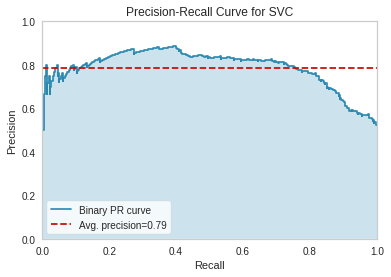

In [30]:
visualizer = PrecisionRecallCurve(svm.SVC(class_weight='balanced'))
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show(outpath="/content/PrecisionRecallCurve.png")

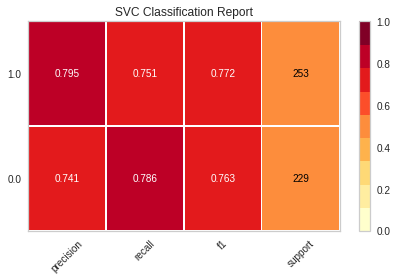

In [31]:
visualizer = ClassificationReport(svm.SVC(class_weight='balanced'), support=True)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show(outpath="/content/ClassificationReport.png")

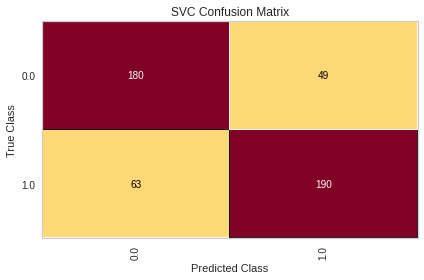

In [32]:
cm = ConfusionMatrix(svm.SVC(class_weight='balanced'))
cm.fit(x_train, y_train)
cm.score(x_test, y_test)
cm.show(outpath="/content/ConfusionMatrix.png")

# CSV

In [24]:
model = svm.SVC()
model.fit(x_train, y_train)
results = model.predict(test_imput)

In [25]:
results_int = [int(result) for result in results]
predictions = pd.DataFrame({'prediction': results_int}, columns = ['prediction'])
predictions.to_csv('/content/results.csv', index=False)
display(predictions)

,prediction
0,1
1,1
2,1
3,0
4,1
...,...
2162,0
2163,0
2164,0
2165,1


In [26]:
sample_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fml/data/sample_valid_predictions.csv')
display(sample_data)

,prediction
0,1
1,0
2,1
3,1
4,1
...,...
2162,0
2163,1
2164,0
2165,1


In [27]:
!zip -r fml.zip *.png results.csv

updating: ClassificationReport.png (deflated 10%)
updating: ConfusionMatrix.png (deflated 14%)
updating: PrecisionRecallCurve.png (deflated 6%)
updating: results.csv (deflated 89%)
